In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

id_path = "registry_ids.csv"
loc_ids = pd.read_csv(id_path).values

In [24]:
def read_and_process_file(file_path):
    result_list = []

    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()

            # Extract every second line
            for i in range(1, len(lines), 2):
                line = lines[i].strip()

                # Split the line into a list of integers
                integer_series = list(map(int, line.split()))

                result_list.append(integer_series)

        return result_list

    except FileNotFoundError:
        print("File not found. Please check the file path.")
        return None
    except Exception as e:
        print("An error occurred:", e)
        return None

def create_csv_from_2d_list(values, loc_ids, file_name="brownfields_top20_output.csv"):
    # Sum each column of the 2D list
    column_sums = [sum(col) for col in zip(*values)]
    # Create a DataFrame with indices and summed column values
    df = pd.DataFrame({
        'loc_ids': loc_ids,
        'obs_values': column_sums})
    df_sorted = df.sort_values(by=df.columns[1], ascending=False)
    # Save the DataFrame to a CSV file in the same directory
    df_sorted.to_csv(file_name, index=False)

def normalize_history(history):
    for line in history:
        sum=0
        for element in line:
            sum=sum+element[1]
        for element in line:
            element[1]=element[1]/sum

def get_history_indices_list(history):
    index_list=[]
    for line in history:
        for element in line:
            if element[0] not in index_list:
                index_list.append(element[0])
    return index_list

def normalize_read_list(list):
    line_counter=0
    for line in list:
        sum=0
        for element in line:
            sum=sum+element
        element_counter=0
        for element in line:
            list[line_counter][element_counter]=element/sum
            element_counter+=1
        line_counter+=1

In [25]:
master_distrib=[0]*16057 # num locs + 1, CAREFUL, this list starts from index 1 TO PLOT the right location indices. The exported location indices also start from 1. 
# The data for brownfield indices start from 0. After exporting the best indices, subtract 1 from them while accessing to brownfield data. 
master_top_10=[[0,0] for i in range(22)]
file_name="recorder.txt"
read_list=read_and_process_file(file_name)
history=[]

# Get the resulting list, normalize it inside each combination length, sum them for each location and get the indices of top n observation rates.
normalize_read_list(read_list)
np_read_list=np.array(read_list)
column_sums = np.sum(np_read_list, axis=0)
indexed_column_sums=[]
for i in range(len(column_sums)):
    indexed_column_sums.append([column_sums[i],i])
np_indexed_column_sums=np.array(indexed_column_sums)
sorted_column_sums = np_indexed_column_sums[np_indexed_column_sums[:, 0].argsort()[::-1]]

trimmed_sums = sorted_column_sums[:20] 

# Get the results of top 20 observed locations
index_list=[x[1] for x in trimmed_sums]
index_list=sorted(index_list)
index_list=[int(x) for x in index_list]
included_history=[]
for line in read_list:
    included_line=[]
    for i in range(len(line)):
        if i in index_list:
            included_line.append(line[i])
    included_history.append(included_line)

np_amplitudes=np.array(included_history)

id_prints=[]
for index in index_list:
    id_prints.append(loc_ids[index])

create_csv_from_2d_list(included_history,id_prints,file_name="loc_id_vs_obs_rate.csv")

In [26]:
image_ids = pd.read_csv("loc_id_vs_obs_rate.csv").values[:,0]

row_sums = np.sum(np_amplitudes, axis=1)
# Get indices to sort in descending order
sorted_indices = np.argsort(row_sums)[::-1]
# Sort the array
sorted_np_amplitudes = np_amplitudes[sorted_indices]

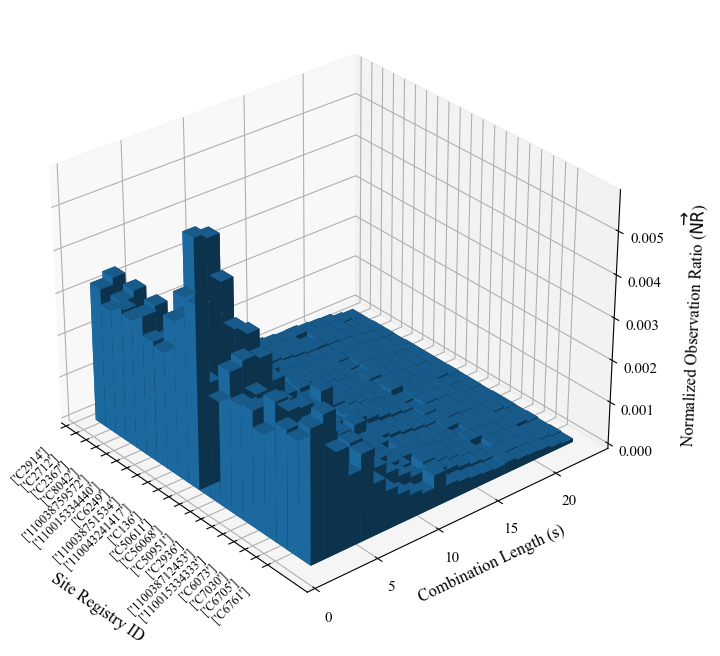

In [29]:
x = np.arange(1, 21)  # 1 to 20
y = np.arange(1, 23)  # 1 to 22
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Flatten the meshgrid arrays to use as coordinates for the bars
x = x.flatten()
y = y.flatten()
z = np.zeros_like(x)  # Z-coordinate for the bottom of the bars

# Set the height of the bars using the data values
dx = dy = 1  # Width and depth of the bars
dz = sorted_np_amplitudes.flatten()

# Create 3D bars
plt.rcParams['font.family'] = ['Times New Roman']
ax.bar3d(x, y, z, dx, dy, dz, shade=True)

figfont = {'fontname':'Times New Roman'}
plt.xticks(fontname = "Times New Roman",fontsize=9)
plt.yticks(fontname = "Times New Roman",fontsize=11)
ax.set_xlabel('Site Registry ID',figfont,fontsize=12,labelpad=40)
ax.set_ylabel('Combination Length (s)',figfont,fontsize=12)
ax.set_zlabel('Normalized Observation Ratio ($\overrightarrow{\mathrm{NR}}$)',figfont,fontsize=12,labelpad=10)
#ax.set_title('Combinatory Analysis Result',figfont,fontsize=12)
for t in ax.zaxis.get_major_ticks(): t.label.set_font('Times New Roman')
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(11)
str_indices=[str(x) for x in image_ids]
x_list=[i for i in range(20)]

plt.xticks(x_list,str_indices,rotation=45, ha='right')
ax.view_init(azim=ax.azim + 20)
plt.savefig("3d_rotated_image.png", dpi=300)
plt.show()
